## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp006'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-5 / warmup_factor #1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

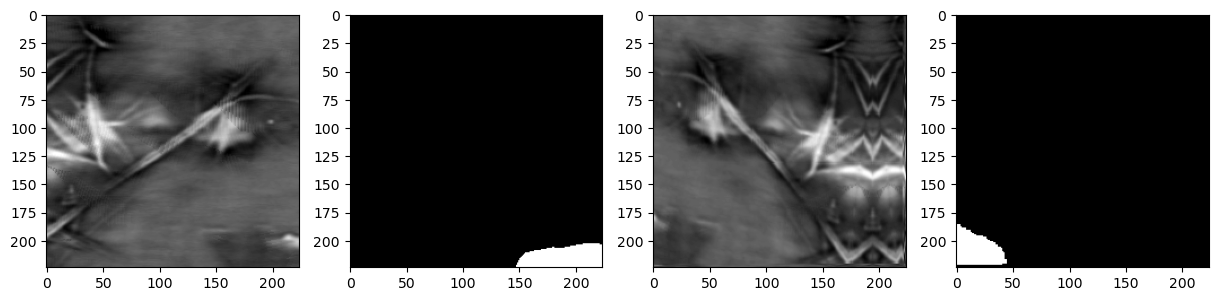

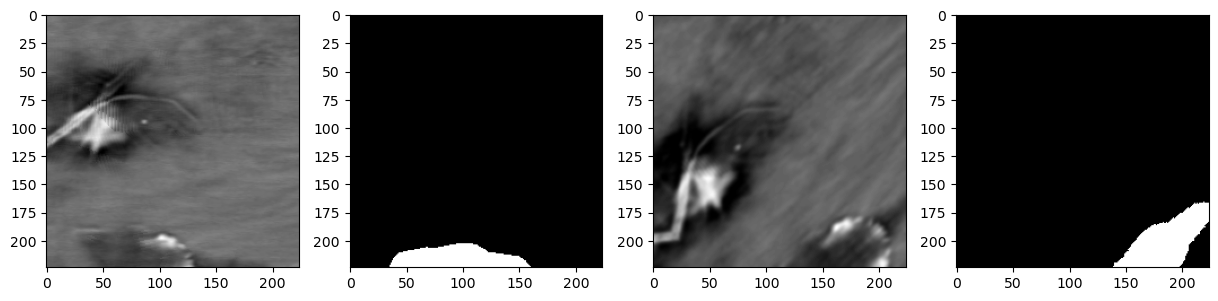

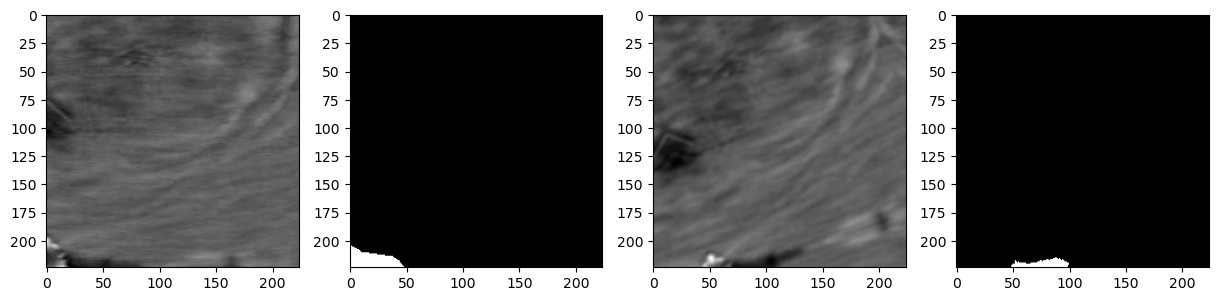

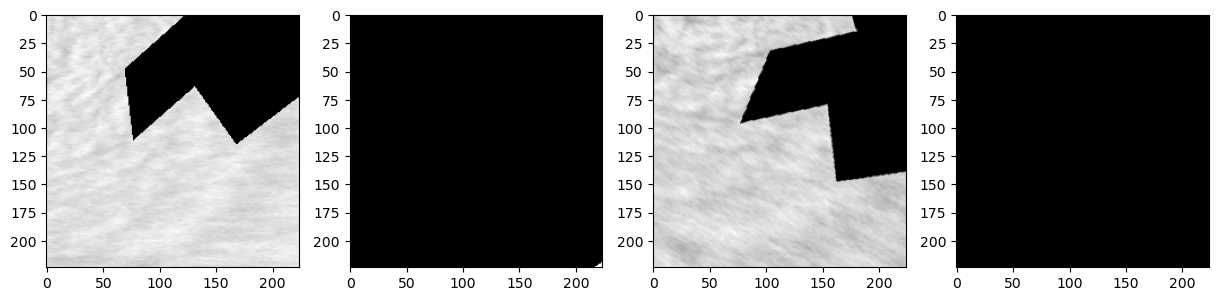

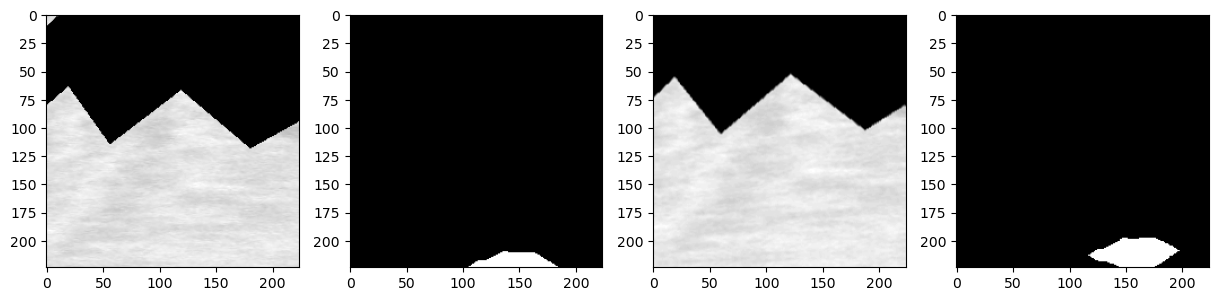

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48105

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12018267536372396
th: 0.15, fbeta: 0.1510327518009017
th: 0.2, fbeta: 0.19527053286951326
th: 0.25, fbeta: 0.2092050907918702
th: 0.3, fbeta: 0.2153657305864114
th: 0.35, fbeta: 0.21679283963820142
th: 0.4, fbeta: 0.21668539439816553
th: 0.45, fbeta: 0.21259791738192205


best_th: 0.35, fbeta: 0.21679283963820142
Epoch 1 - avg_train_loss: 0.5235  avg_val_loss: 0.4269  time: 226s
Epoch 1 - avgScore: 0.2168
Epoch 1 - Save Best Score: 0.2168 Model
Epoch 1 - Save Best Loss: 0.4269 Model


th: 0.5, fbeta: 0.1993926476434065


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12101711092634791
th: 0.15, fbeta: 0.166208154852454
th: 0.2, fbeta: 0.20881313176442187
th: 0.25, fbeta: 0.22430751718267022
th: 0.3, fbeta: 0.2310237217412219
th: 0.35, fbeta: 0.23580331562690515
th: 0.4, fbeta: 0.23706282061322237
th: 0.45, fbeta: 0.23112106331222912


best_th: 0.4, fbeta: 0.23706282061322237
Epoch 2 - avg_train_loss: 0.4563  avg_val_loss: 0.4040  time: 228s
Epoch 2 - avgScore: 0.2371
Epoch 2 - Save Best Score: 0.2371 Model
Epoch 2 - Save Best Loss: 0.4040 Model


th: 0.5, fbeta: 0.21030615245455656


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.16347508333610963
th: 0.15, fbeta: 0.2396728921692633
th: 0.2, fbeta: 0.2690802736996777
th: 0.25, fbeta: 0.29946031001386475
th: 0.3, fbeta: 0.3325282584957425
th: 0.35, fbeta: 0.3662052691358523
th: 0.4, fbeta: 0.39754060864195695
th: 0.45, fbeta: 0.42099824536995684


best_th: 0.5, fbeta: 0.4261053000811372
Epoch 3 - avg_train_loss: 0.3726  avg_val_loss: 0.3118  time: 228s
Epoch 3 - avgScore: 0.4261
Epoch 3 - Save Best Score: 0.4261 Model
Epoch 3 - Save Best Loss: 0.3118 Model


th: 0.5, fbeta: 0.4261053000811372


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23385828219298185
th: 0.15, fbeta: 0.2790399733088946
th: 0.2, fbeta: 0.3207789407079678
th: 0.25, fbeta: 0.35551870592912105
th: 0.3, fbeta: 0.3834714519721275
th: 0.35, fbeta: 0.40473143839210657
th: 0.4, fbeta: 0.42085463064313094
th: 0.45, fbeta: 0.43090429536498204


best_th: 0.5, fbeta: 0.43481591044346063
Epoch 4 - avg_train_loss: 0.3046  avg_val_loss: 0.2802  time: 228s
Epoch 4 - avgScore: 0.4348
Epoch 4 - Save Best Score: 0.4348 Model
Epoch 4 - Save Best Loss: 0.2802 Model


th: 0.5, fbeta: 0.43481591044346063


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.281547738303558
th: 0.15, fbeta: 0.338461354088051
th: 0.2, fbeta: 0.3757859622303815
th: 0.25, fbeta: 0.39916128974216897
th: 0.3, fbeta: 0.414262694825969
th: 0.35, fbeta: 0.42631297197967755
th: 0.4, fbeta: 0.4356805893861358
th: 0.45, fbeta: 0.4410241558150579


best_th: 0.45, fbeta: 0.4410241558150579
Epoch 5 - avg_train_loss: 0.2749  avg_val_loss: 0.2595  time: 228s
Epoch 5 - avgScore: 0.4410
Epoch 5 - Save Best Score: 0.4410 Model
Epoch 5 - Save Best Loss: 0.2595 Model


th: 0.5, fbeta: 0.4394638367003047


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29086595575489976
th: 0.15, fbeta: 0.33829889224888227
th: 0.2, fbeta: 0.37426449899296954
th: 0.25, fbeta: 0.40369496193556387
th: 0.3, fbeta: 0.42728100751304493
th: 0.35, fbeta: 0.4448651343635304
th: 0.4, fbeta: 0.45776002443243685
th: 0.45, fbeta: 0.4677310781269392


best_th: 0.5, fbeta: 0.4762103529356867
Epoch 6 - avg_train_loss: 0.2562  avg_val_loss: 0.2498  time: 228s
Epoch 6 - avgScore: 0.4762
Epoch 6 - Save Best Score: 0.4762 Model
Epoch 6 - Save Best Loss: 0.2498 Model


th: 0.5, fbeta: 0.4762103529356867


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2966438408249228
th: 0.15, fbeta: 0.33589925406404036
th: 0.2, fbeta: 0.36729023162017416
th: 0.25, fbeta: 0.39407509604178403
th: 0.3, fbeta: 0.4168606432637229
th: 0.35, fbeta: 0.4339891540013802
th: 0.4, fbeta: 0.4476826436792063
th: 0.45, fbeta: 0.4597724265750869


best_th: 0.5, fbeta: 0.4704149754253926
Epoch 7 - avg_train_loss: 0.2455  avg_val_loss: 0.2485  time: 228s
Epoch 7 - avgScore: 0.4704


th: 0.5, fbeta: 0.4704149754253926


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3094611170245009
th: 0.15, fbeta: 0.34769218259882045
th: 0.2, fbeta: 0.37588558792784293
th: 0.25, fbeta: 0.3983755577917258
th: 0.3, fbeta: 0.4146390586546323
th: 0.35, fbeta: 0.42842086511778005
th: 0.4, fbeta: 0.4414516162900434
th: 0.45, fbeta: 0.45010064124167987


best_th: 0.5, fbeta: 0.4536377530385828
Epoch 8 - avg_train_loss: 0.2346  avg_val_loss: 0.2467  time: 226s
Epoch 8 - avgScore: 0.4536


th: 0.5, fbeta: 0.4536377530385828


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3276925458321232
th: 0.15, fbeta: 0.35594129421988874
th: 0.2, fbeta: 0.37086312147764855
th: 0.25, fbeta: 0.38080461366188884
th: 0.3, fbeta: 0.3896917893322869
th: 0.35, fbeta: 0.3994336824221878
th: 0.4, fbeta: 0.4084441590827065
th: 0.45, fbeta: 0.41490143212934794


best_th: 0.5, fbeta: 0.4171835601341104
Epoch 9 - avg_train_loss: 0.2255  avg_val_loss: 0.2600  time: 227s
Epoch 9 - avgScore: 0.4172


th: 0.5, fbeta: 0.4171835601341104


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3346273583805662
th: 0.15, fbeta: 0.365568691480758
th: 0.2, fbeta: 0.3897414512138534
th: 0.25, fbeta: 0.4120244768407869
th: 0.3, fbeta: 0.4310063156363115
th: 0.35, fbeta: 0.44720190015469297
th: 0.4, fbeta: 0.4617992739052548
th: 0.45, fbeta: 0.47020698682869544


best_th: 0.5, fbeta: 0.47465410220241994
Epoch 10 - avg_train_loss: 0.2220  avg_val_loss: 0.2483  time: 227s
Epoch 10 - avgScore: 0.4747


th: 0.5, fbeta: 0.47465410220241994


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34870389937627444
th: 0.15, fbeta: 0.3834308157808718
th: 0.2, fbeta: 0.41178473027664697
th: 0.25, fbeta: 0.43358718018012743
th: 0.3, fbeta: 0.4475433312926857
th: 0.35, fbeta: 0.4567413586712776
th: 0.4, fbeta: 0.46268385154066116
th: 0.45, fbeta: 0.4648032483453265


best_th: 0.5, fbeta: 0.4654063370438153
Epoch 11 - avg_train_loss: 0.2157  avg_val_loss: 0.2485  time: 228s
Epoch 11 - avgScore: 0.4654


th: 0.5, fbeta: 0.4654063370438153


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3488109987681408
th: 0.15, fbeta: 0.3770063789375562
th: 0.2, fbeta: 0.3975124127110986
th: 0.25, fbeta: 0.4153244584763043
th: 0.3, fbeta: 0.43050768434461073
th: 0.35, fbeta: 0.4422320808972857
th: 0.4, fbeta: 0.4536079034937627
th: 0.45, fbeta: 0.4610553016742086


best_th: 0.5, fbeta: 0.46250142440148695
Epoch 12 - avg_train_loss: 0.2061  avg_val_loss: 0.2595  time: 227s
Epoch 12 - avgScore: 0.4625


th: 0.5, fbeta: 0.46250142440148695


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35753356948837056
th: 0.15, fbeta: 0.3896101764396041
th: 0.2, fbeta: 0.41481057892281553
th: 0.25, fbeta: 0.43365335689689566
th: 0.3, fbeta: 0.45106852987269563
th: 0.35, fbeta: 0.4652190089183253
th: 0.4, fbeta: 0.47352538708273934
th: 0.45, fbeta: 0.4776107268878124


best_th: 0.45, fbeta: 0.4776107268878124
Epoch 13 - avg_train_loss: 0.2030  avg_val_loss: 0.2488  time: 229s
Epoch 13 - avgScore: 0.4776
Epoch 13 - Save Best Score: 0.4776 Model
Epoch 13 - Save Best Loss: 0.2488 Model


th: 0.5, fbeta: 0.47701772515156704


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38746162856008365
th: 0.15, fbeta: 0.43012144851930245
th: 0.2, fbeta: 0.4583716994838643
th: 0.25, fbeta: 0.47640028721358985
th: 0.3, fbeta: 0.4853992067722925
th: 0.35, fbeta: 0.4880229775719318
th: 0.4, fbeta: 0.48638183555505
th: 0.45, fbeta: 0.47866711002225193


best_th: 0.35, fbeta: 0.4880229775719318
Epoch 14 - avg_train_loss: 0.1974  avg_val_loss: 0.2579  time: 229s
Epoch 14 - avgScore: 0.4880
Epoch 14 - Save Best Score: 0.4880 Model
Epoch 14 - Save Best Loss: 0.2579 Model


th: 0.5, fbeta: 0.46605845022685977


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34295508114274853
th: 0.15, fbeta: 0.3663676162405857
th: 0.2, fbeta: 0.38755712024279804
th: 0.25, fbeta: 0.406585600731571
th: 0.3, fbeta: 0.42200731260480384
th: 0.35, fbeta: 0.43566033278758504
th: 0.4, fbeta: 0.4480408524839052
th: 0.45, fbeta: 0.4580460089823038


best_th: 0.5, fbeta: 0.46268337409262883
Epoch 15 - avg_train_loss: 0.1896  avg_val_loss: 0.2657  time: 227s
Epoch 15 - avgScore: 0.4627


th: 0.5, fbeta: 0.46268337409262883


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3898620619091705
th: 0.15, fbeta: 0.42618668732221265
th: 0.2, fbeta: 0.45740585668318895
th: 0.25, fbeta: 0.47959918679776137
th: 0.3, fbeta: 0.4925479848703956
th: 0.35, fbeta: 0.49869323033649554
th: 0.4, fbeta: 0.5020415868320864
th: 0.45, fbeta: 0.5021020276081888


best_th: 0.45, fbeta: 0.5021020276081888
Epoch 16 - avg_train_loss: 0.1882  avg_val_loss: 0.2533  time: 228s
Epoch 16 - avgScore: 0.5021
Epoch 16 - Save Best Score: 0.5021 Model
Epoch 16 - Save Best Loss: 0.2533 Model


th: 0.5, fbeta: 0.4952318194648946


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36331661545629884
th: 0.15, fbeta: 0.395186382698834
th: 0.2, fbeta: 0.42328762565200273
th: 0.25, fbeta: 0.44350962588861803
th: 0.3, fbeta: 0.46038917968454923
th: 0.35, fbeta: 0.47445973767068006
th: 0.4, fbeta: 0.4827241782824214
th: 0.45, fbeta: 0.48552745163572525


best_th: 0.45, fbeta: 0.48552745163572525
Epoch 17 - avg_train_loss: 0.1840  avg_val_loss: 0.2548  time: 228s
Epoch 17 - avgScore: 0.4855


th: 0.5, fbeta: 0.4849297445614935


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38007734420991784
th: 0.15, fbeta: 0.41236285850708043
th: 0.2, fbeta: 0.43765495985483055
th: 0.25, fbeta: 0.4602942210996226
th: 0.3, fbeta: 0.4760936993007191
th: 0.35, fbeta: 0.4871408805030698
th: 0.4, fbeta: 0.49241596695989126
th: 0.45, fbeta: 0.4933918207345085


best_th: 0.45, fbeta: 0.4933918207345085
Epoch 18 - avg_train_loss: 0.1792  avg_val_loss: 0.2579  time: 228s
Epoch 18 - avgScore: 0.4934


th: 0.5, fbeta: 0.49103825853556154


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3872028886976167
th: 0.15, fbeta: 0.41495627104204236
th: 0.2, fbeta: 0.43826510922780937
th: 0.25, fbeta: 0.45581787677626373
th: 0.3, fbeta: 0.4687473103970896
th: 0.35, fbeta: 0.47558152991356234
th: 0.4, fbeta: 0.4771302534615545
th: 0.45, fbeta: 0.4724919224102338


best_th: 0.4, fbeta: 0.4771302534615545
Epoch 19 - avg_train_loss: 0.1757  avg_val_loss: 0.2730  time: 227s
Epoch 19 - avgScore: 0.4771


th: 0.5, fbeta: 0.46402279216884695


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.371332982060561
th: 0.15, fbeta: 0.39845278320822675
th: 0.2, fbeta: 0.4190611538699599
th: 0.25, fbeta: 0.43638522966646426
th: 0.3, fbeta: 0.45156951942061885
th: 0.35, fbeta: 0.4655290791521295
th: 0.4, fbeta: 0.47705435637971905
th: 0.45, fbeta: 0.48478333613793967


best_th: 0.5, fbeta: 0.48717801533147365
Epoch 20 - avg_train_loss: 0.1732  avg_val_loss: 0.2704  time: 228s
Epoch 20 - avgScore: 0.4872


th: 0.5, fbeta: 0.48717801533147365


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3925354261701267
th: 0.15, fbeta: 0.421856037680546
th: 0.2, fbeta: 0.4479130966294161
th: 0.25, fbeta: 0.4690433097928367
th: 0.3, fbeta: 0.48493674265290176
th: 0.35, fbeta: 0.49728376170739796
th: 0.4, fbeta: 0.5036112535874694
th: 0.45, fbeta: 0.5037032795786974


best_th: 0.45, fbeta: 0.5037032795786974
Epoch 21 - avg_train_loss: 0.1713  avg_val_loss: 0.2636  time: 228s
Epoch 21 - avgScore: 0.5037
Epoch 21 - Save Best Score: 0.5037 Model
Epoch 21 - Save Best Loss: 0.2636 Model


th: 0.5, fbeta: 0.4984024756045502


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3719900643433833
th: 0.15, fbeta: 0.3976472612060208
th: 0.2, fbeta: 0.4203368249400555
th: 0.25, fbeta: 0.4417940139345563
th: 0.3, fbeta: 0.4605525724539457
th: 0.35, fbeta: 0.4744251428547569
th: 0.4, fbeta: 0.4833580745920949
th: 0.45, fbeta: 0.4856507892069771


best_th: 0.45, fbeta: 0.4856507892069771
Epoch 22 - avg_train_loss: 0.1671  avg_val_loss: 0.2690  time: 227s
Epoch 22 - avgScore: 0.4857


th: 0.5, fbeta: 0.4817295467654974


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3873432082961938
th: 0.15, fbeta: 0.4128039295367242
th: 0.2, fbeta: 0.4351161445515701
th: 0.25, fbeta: 0.45552537759930145
th: 0.3, fbeta: 0.4718406327108267
th: 0.35, fbeta: 0.48394907531538767
th: 0.4, fbeta: 0.49057662206799535
th: 0.45, fbeta: 0.49070893449620834


best_th: 0.45, fbeta: 0.49070893449620834
Epoch 23 - avg_train_loss: 0.1651  avg_val_loss: 0.2699  time: 226s
Epoch 23 - avgScore: 0.4907


th: 0.5, fbeta: 0.4830851317531913


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38416416356461647
th: 0.15, fbeta: 0.41097187180353234
th: 0.2, fbeta: 0.4323093425938321
th: 0.25, fbeta: 0.4501395566129378
th: 0.3, fbeta: 0.46420593025350465
th: 0.35, fbeta: 0.47619317988803556
th: 0.4, fbeta: 0.48244278979868316
th: 0.45, fbeta: 0.4816375092953229


best_th: 0.4, fbeta: 0.48244278979868316
Epoch 24 - avg_train_loss: 0.1638  avg_val_loss: 0.2753  time: 227s
Epoch 24 - avgScore: 0.4824


th: 0.5, fbeta: 0.47386507169457354


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34865586051957714
th: 0.15, fbeta: 0.3764202983278414
th: 0.2, fbeta: 0.40048796596851816
th: 0.25, fbeta: 0.4206500018255341
th: 0.3, fbeta: 0.43828367803397966
th: 0.35, fbeta: 0.4545966578014979
th: 0.4, fbeta: 0.46898392592229177
th: 0.45, fbeta: 0.478818200657631


best_th: 0.5, fbeta: 0.48200187264941263
Epoch 25 - avg_train_loss: 0.1621  avg_val_loss: 0.2612  time: 228s
Epoch 25 - avgScore: 0.4820


th: 0.5, fbeta: 0.48200187264941263


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38063753329123834
th: 0.15, fbeta: 0.40351235297114485
th: 0.2, fbeta: 0.4250377627742413
th: 0.25, fbeta: 0.44274050861739095
th: 0.3, fbeta: 0.4563218152214332
th: 0.35, fbeta: 0.4687202903322346
th: 0.4, fbeta: 0.476647544668451
th: 0.45, fbeta: 0.4810904944819325


best_th: 0.45, fbeta: 0.4810904944819325
Epoch 26 - avg_train_loss: 0.1601  avg_val_loss: 0.2833  time: 230s
Epoch 26 - avgScore: 0.4811


th: 0.5, fbeta: 0.48001818541482777


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36507373926618714
th: 0.15, fbeta: 0.3868188834314388
th: 0.2, fbeta: 0.4075355061071506
th: 0.25, fbeta: 0.42583756134408646
th: 0.3, fbeta: 0.44216212509640196
th: 0.35, fbeta: 0.4556932357761096
th: 0.4, fbeta: 0.4654378241823275
th: 0.45, fbeta: 0.4732317873569492


best_th: 0.5, fbeta: 0.47780772426398155
Epoch 27 - avg_train_loss: 0.1586  avg_val_loss: 0.2795  time: 228s
Epoch 27 - avgScore: 0.4778


th: 0.5, fbeta: 0.47780772426398155


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3810499447767431
th: 0.15, fbeta: 0.4049587733889498
th: 0.2, fbeta: 0.4261939383292877
th: 0.25, fbeta: 0.44515291424748904
th: 0.3, fbeta: 0.4619466443529829
th: 0.35, fbeta: 0.47525040234165006
th: 0.4, fbeta: 0.48500475260533643
th: 0.45, fbeta: 0.48863454107708987


best_th: 0.45, fbeta: 0.48863454107708987
Epoch 28 - avg_train_loss: 0.1572  avg_val_loss: 0.2803  time: 229s
Epoch 28 - avgScore: 0.4886


th: 0.5, fbeta: 0.48661702533707424


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38853966485228425
th: 0.15, fbeta: 0.414436614109814
th: 0.2, fbeta: 0.437970155238835
th: 0.25, fbeta: 0.45892324153857594
th: 0.3, fbeta: 0.47399768757807853
th: 0.35, fbeta: 0.4879275227186363
th: 0.4, fbeta: 0.49660720071691605
th: 0.45, fbeta: 0.49802173043650655


best_th: 0.45, fbeta: 0.49802173043650655
Epoch 29 - avg_train_loss: 0.1565  avg_val_loss: 0.2772  time: 230s
Epoch 29 - avgScore: 0.4980


th: 0.5, fbeta: 0.49320437100914793


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37203073358436367
th: 0.15, fbeta: 0.399836199267875
th: 0.2, fbeta: 0.4242294100522875
th: 0.25, fbeta: 0.4471283370642821
th: 0.3, fbeta: 0.46386872577049065
th: 0.35, fbeta: 0.4751116140971409
th: 0.4, fbeta: 0.4834237686398195
th: 0.45, fbeta: 0.4865688856877254


best_th: 0.45, fbeta: 0.4865688856877254
Epoch 30 - avg_train_loss: 0.1563  avg_val_loss: 0.2716  time: 231s
Epoch 30 - avgScore: 0.4866


th: 0.5, fbeta: 0.4830757518792243


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3925354261701267
th: 0.15, fbeta: 0.421856037680546
th: 0.2, fbeta: 0.4479130966294161
th: 0.25, fbeta: 0.4690433097928367
th: 0.3, fbeta: 0.48493674265290176
th: 0.35, fbeta: 0.49728376170739796
th: 0.4, fbeta: 0.5036112535874694
th: 0.45, fbeta: 0.5037032795786974


best_th: 0.45, fbeta: 0.5037032795786974


th: 0.5, fbeta: 0.4984024756045502


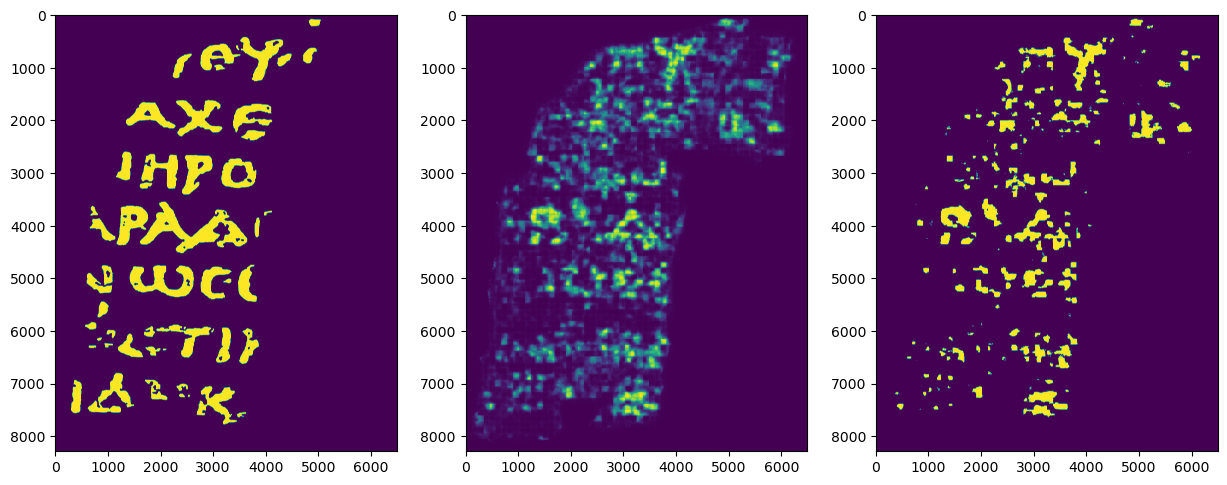

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([39409320.,  3807108.,  2031930.,  1430406.,  1112137.,   882562.,
          736310.,   642902.,   593983.,   514037.,   424803.,   379443.,
          348000.,   302010.,   266220.,   252235.,   244617.,   229523.,
          169890.,    61412.]),
 array([3.59035312e-05, 4.86890901e-02, 9.73422766e-02, 1.45995463e-01,
        1.94648650e-01, 2.43301836e-01, 2.91955023e-01, 3.40608209e-01,
        3.89261396e-01, 4.37914582e-01, 4.86567769e-01, 5.35220955e-01,
        5.83874142e-01, 6.32527328e-01, 6.81180515e-01, 7.29833701e-01,
        7.78486888e-01, 8.27140074e-01, 8.75793261e-01, 9.24446448e-01,
        9.73099634e-01]),
 <BarContainer object of 20 artists>)

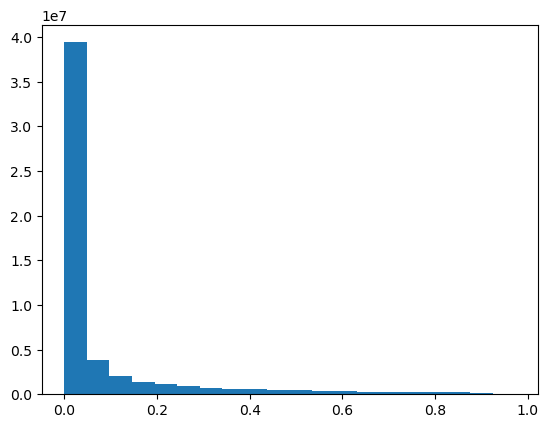

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000